---
authors: 
  - Mehraj Khalid
  - John Sia
---
# Druk, temperatuur en energie

## Doelen

Om het gedrag van een gas beter te begrijpen moeten we de microscopische eigenschappen van ons model (zoals massa, snelheid, impuls en energie per deeltje) nu verbinden aan de macroscopische eigenschappen van het systeem (zoals druk en temperatuur).
We gaan ons model dus uitbreiden met code om deze macroscopische eigenschappen te berekenen.

Eerst nemen we alle delen over van de code die we opnieuw moeten gebruiken:
- class voor particles
- functies voor detecteren botsingen
- (toelichten van een snellere manier van programmeren).

Daarna voegen we de code toe voor de nieuwe macroscopische eigenschappen:
- een functie schrijven voor de temperatuur
- een functie schrijven voor de druk

En dan maken we een simulatie, controleren we de resultaten en verbeteren we eventueel de code. 

## Externe bronnen
Bij het maken van deze module kun je de Feynman lectures on Physics erg goed gebruiken.
We bevelen aan:
- [The Kinetic Theory of Gases](https://www.feynmanlectures.caltech.edu/I_39.html) voor het afleiden van de druk, en het botsingsmodel.


## Laden van alle code die we al ontwikkeld hebben

Eerst roepen we de juiste pakketten van Python aan en bepalen we de waardes van de constanten van onze simulatie.

```{exercise}
Neem de constanten die je in het vorige werkblad hebt gekozen hieronder over.
```

In [153]:
# ruimte voor uitwerking

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

BOX_SIZE_0 = 10              # Hoogte en lengte startvolume
N = 40                       # Aantal deeltjes 
V_0 = 1                      # Startsnelheid van deeltjes 
RADIUS = 0.5                 # Straal van moleculen 
DT = 0.04                    # Tijdstap 


De klasse voor de gasmoleculen en de functies voor hun onderlinge interactie:

In [170]:
class ParticleClass:
    def __init__(self, m, v, r, R):
        """ maakt een deeltje (constructor) """
        self.m = m                         
        self.v = np.array(v, dtype=float)  
        self.r = np.array(r, dtype=float)  
        self.R = R

    def update_position(self):
        """ verandert positie voor één tijdstap """
        self.r += self.v * DT 
            
    @property
    def momentum(self):
        return self.m * self.v
    
    @property
    def kin_energy(self):
        return 1/2 * self.m * np.dot(self.v, self.v)
    
def collide_detection(p1: ParticleClass, p2: ParticleClass) -> bool:
    """ Geeft TRUE als de deeltjes overlappen """
    dx = p1.r[0] - p2.r[0]
    dy = p1.r[1] - p2.r[1]
    rr = p1.R + p2.R
    return  dx**2+dy**2 < rr**2 

def particle_collision(p1: ParticleClass, p2: ParticleClass):
    """ past snelheden aan uitgaande van overlap """
    m1, m2 = p1.m, p2.m
    delta_r = p1.r - p2.r
    delta_v = p1.v - p2.v
    dot_product = np.dot(delta_r, delta_v)

    # Als deeltjes van elkaar weg bewegen dan geen botsing
    if dot_product >= 0: # '='-teken voorkomt ook problemen als delta_r == \vec{0}
        return

    distance_squared = np.dot(delta_r, delta_r) 
    # Botsing oplossen volgens elastische botsing in 2D
    p1.v -= 2 * m2 / (m1 + m2) * dot_product / distance_squared * delta_r
    p2.v += 2 * m1 / (m1 + m2) * dot_product / distance_squared * delta_r

Het volume met de 'oude' randvoorwaarden. Dit zijn niet de randvoorwaarden van het vorige werkblad, maar de randvoorwaarden die je eerder hebt gebruikt. Hierbij botsen de deeltjes elastisch met de wanden van het volume. 

In [155]:
def box_collision(particle: ParticleClass):
    ''' botsing met harde wanden '''
    if abs(particle.r[0]) + particle.R > BOX_SIZE_0/2: 
        particle.v[0] = -particle.v[0]                                        # Omdraaien van de snelheid
        particle.r[0] = np.sign(particle.r[0]) * (BOX_SIZE_0/2 - particle.R)  # Zet terug net binnen box                 
    if abs(particle.r[1]) + particle.R > BOX_SIZE_0/2: 
        particle.v[1] = -particle.v[1]     
        particle.r[1] = np.sign(particle.r[1]) * (BOX_SIZE_0/2 - particle.R) 

Het uitvoeren en samennemen van deze functies over een lijst met deeltjes:

In [156]:
def create_particles(particles):
    """ Leegmaken en opnieuw aanmaken van deeltjes  in lijst """
    particles.clear()
    for i in range(N):
        vx = np.random.uniform(-V_0, V_0)
        vy = np.random.choice([-1, 1]) * np.sqrt(V_0**2 - vx**2)        
        pos = np.random.uniform(-BOX_SIZE_0/2 + RADIUS, BOX_SIZE_0/2 - RADIUS, 2)
        particles.append(ParticleClass(m=1.0, v=[vx, vy], r=pos, R=RADIUS))

# note dat deze handle_collisions functie anders is dan we gedaan in brownian motion
# controleer zelf welke van de twee functies sneller is (wat, zoals gezegd, sterk afhangt van het aantal deeltjes!)
def handle_collisions(particles):
    """ alle onderlinge botsingen afhandelen voor deeltjes in lijst """
    num_particles = len(particles)
    for i in range(num_particles):
        for j in range(i+1, num_particles):
            if collide_detection(particles[i], particles[j]):
                particle_collision(particles[i], particles[j])

def handle_walls(particles):
    """ botsing met wanden controleren voor alle deeltjes in lijst """
    for p in particles:
        box_collision(p)

# de eigenlijke stappen in de simulatie
def take_time_step(particles):
    """ zet tijdstap voor een lijst deeltjes en verwerk alle botsingen onderling en met wanden """
    for p in particles:
        p.update_position()
    handle_collisions(particles)
    handle_walls(particles)  


## Het draaien van een eerste simulatie ter controle

Laten we het eerst zo eenvoudig mogelijk maken en controleren of het lukt om honderd tijdstappen te zetten met de hierboven gedefinieerde functies. 
Als resultaat beperken we ons tot het plotten van de posities van de deeltjes en hun snelheden.

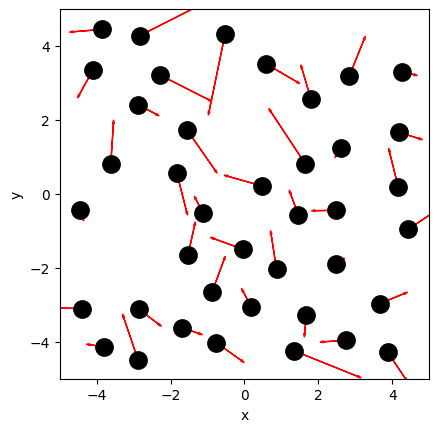

In [157]:
particles = []
create_particles(particles)

# doorlopen van de simulatie
for i in range(100):
    take_time_step(particles)

# plotten van de positie van de deeltjes en hun snelheid als vector
plt.figure()
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal')
plt.xlim(-BOX_SIZE_0/2, BOX_SIZE_0/2)
plt.ylim(-BOX_SIZE_0/2, BOX_SIZE_0/2)

for p in particles:
    plt.plot(p.r[0], p.r[1], 'k.', ms=25)
    plt.arrow(p.r[0], p.r[1], p.v[0], p.v[1], 
              head_width=0.05, head_length=0.1, color='red')
plt.show()

## Temperatuur

Het boek behandelt de microscopische formules helemaal niet, maar de thermische energie van een gas is niets anders dan de statistisch gemiddelde kinetische energie van de deeltjes waaruit het gas bestaat.
Nu is er van alles te zeggen over deze statistiek, maar voor nu gaan we daar even aan voorbij.
Dat is onderwerp van het volgende werkblad.

De temperatuur wordt gegeven door:

$$
    \frac{f}{2}kT=\frac{1}{2}m\left<v^2\right>
$$

Hierbij is 

- $k$ de constante van Boltzmann ($1.380649\times10^{-23} \mathrm{ JK}^{-1}$)
- $f$ het aantal vrijheidsgraden (het aantal dimensies waarin het gas kan bewegen)
- $T$ de temperatuur (in $\mathrm{kelvin}$)
- $m$ de massa van de deeltjes (in $\mathrm{kg}$)
- $v$ de snelheid van de deeltjes (in $\mathrm{ms}^{-1}$)

```{exercise} Temperatuurfunctie
:label: ex-drukdremp-1

Schrijf een functie die de temperatuur van het gas in onze simulatie bepaalt:
```

In [158]:
def temperature(particles) -> float:
    temp = 0.0
    # We berekenen eerst de totale kinetische energie van alle deeltjes
    total_kin_energy = 0.0
    for p in particles:
        total_kin_energy += p.kin_energy
    
    # Bepaal het gemiddelde kinetische energie per deeltje
    avg_kin_energy = total_kin_energy / len(particles)
    
    # In 2D (f=2) geldt: <E_kin> = k * T.
    # In model-eenheden is k = 1, dus T is gelijk aan de gemiddelde energie.
    temp = avg_kin_energy
    
    return temp

```{exercise} Temperatuurplot
:label: ex-druktemp-2

Gebruik deze functie om een simulatie te maken waarin je de temperatuur als functie van de tijdstap voor 100 tijdstappen plot.
```

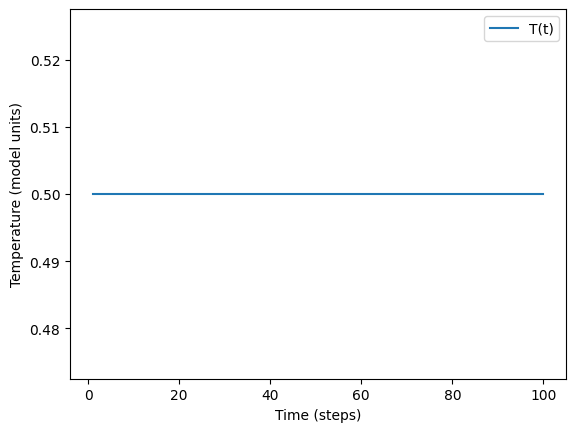

In [159]:


particles = []
temperatures = np.zeros(100, dtype=float)
times = np.linspace(1, 100, 100)

create_particles(particles)

for i in range(100):
    take_time_step(particles)
    # vastleggen van temperatuur per tijdstap
    temperatures[i] = temperature(particles)

plt.figure()
plt.xlabel('Time (steps)')
plt.ylabel('Temperature (model units)')

# plotten van tijd tegen temperatuur
plt.plot(times, temperatures, label='T(t)')
plt.legend()
plt.show()

```{exercise}
:label: ex-druktemp-3

De assen moeten natuurlijk ook eenheden hebben.
In een vorige module heb je de vermenigvuldigingsfactoren en eenheden bij de constanten van deze simulatie bepaald.
- Breid de berekening uit, zodat de eenheden kloppen bij het model dat we probeerden weer te geven.
```

In [160]:
# Exercise 4: Temperatuur met eenheden (Kelvin)

# 1. de Boltzmann-constante in SI-eenheden (J/K)
KB = 1.380649e-23

# 2. schaalfacoren
# voorbeeldwaarden voor N2 moleculen in een nanoschaal doosje
UNIT_MASS   = 4.65e-26  # kg (massa van één N2 molecuul)
UNIT_LENGTH = 1e-9      # m  (1 lengte-eenheid = 1 nanometer)
UNIT_TIME   = 2e-12     # s  (1 tijdseenheid = 2 picoseconden)

# Afgeleide eenheid voor snelheid (m/s)
UNIT_VELOCITY = UNIT_LENGTH / UNIT_TIME

def temperature(particles) -> float:
    """
    Berekent de temperatuur van het gas in Kelvin (K).
    Gebruikt de formule: <E_kin> = k * T  (voor 2D, f=2)
    """
    total_kin_energy_si = 0.0
    
    for p in particles:
        # Reken massa en snelheid om naar SI-eenheden (kg en m/s)
        m_si = p.m * UNIT_MASS
        
        # p.v[0] is vx, p.v[1] is vy
        v_si_x = p.v[0] * UNIT_VELOCITY
        v_si_y = p.v[1] * UNIT_VELOCITY
        
        # Bereken v^2 in (m/s)^2
        v_sq_si = v_si_x**2 + v_si_y**2
        
        # Kinetische energie in Joule (J): 0.5 * m * v^2
        kin_energy_si = 0.5 * m_si * v_sq_si
        
        total_kin_energy_si += kin_energy_si

    # Gemiddelde kinetische energie per deeltje
    if len(particles) == 0:
        return 0.0
        
    avg_kin_energy_si = total_kin_energy_si / len(particles)

    # In 2 dimensies geldt: E_gem = (f/2) * k * T met f=2.
    # Dus: E_gem = 1 * k * T  =>  T = E_gem / k
    T_kelvin = avg_kin_energy_si / KB
    
    return T_kelvin

# Test de functie direct even (optioneel)
print(f"De temperatuur is nu: {temperature(particles):.2f} Kelvin")

De temperatuur is nu: 421.00 Kelvin


## Druk

De druk van een gas is lastiger te berekenen dan de temperatuur.
Het is letterlijk de druk van de gasmoleculen tegen de wanden van het volume. 

$$ 
    P = \frac{F}{A} \stackrel{2D}{=} \frac{F}{l} = \frac{dp / dt}{l} \approx \frac{\Delta p}{l\Delta t} 
$$

Hierbij is:

- $P$ de druk (hoofdletter om te onderscheiden t.o.v. impuls)
- $A$ het oppervlak van de wand (voor de 3D situatie)
- $l$ de lengte van de wand (voor de 2D situatie)
- $p$ de impuls van het gasdeeltje

In de laatste stap hebben we de afgeleide vervangen door het verschil over een tijdstap, omdat die informatie makkelijk uit onze simulatie te halen is.
Om de druk op de wand te bepalen, moeten we dus de verandering van de impuls van de wand bepalen.
In het Nederlands wordt de verandering van impuls ook wel 'stoot' genoemd.
Onhandig is dat de Engelse term hiervoor 'impulse' is.

De wand in ons experiment staat natuurlijk stil, maar ook hier geldt de wet van behoud van impuls (let op: dit is de Nederlandse impuls, die in het Engels 'momentum' heet).
We kunnen dus kijken naar de verandering van impuls van de moleculen op het moment dat deze botsen met de wand.
Daarvoor maken we een nieuwe versie van de functie `handle_walls` die voor het afhandelen van deze botsing wordt aangeroepen.

We kiezen ervoor om de botsingen met de wanden hierbij te splitsen in twee functies: eentje voor de verticale wanden en een voor de horizontale wanden.
Dat lijkt nu nog wat overdreven, maar als het model straks verder wordt uitgebreid houdt dit de code het meest overzichtelijk.

```{note}
Let op het gebruik van variabelen en het gebied waarbinnen ze gelden (genaamd 'scope'). In de functie `handle_walls` wordt gebruik gemaakt van een variabele `p`. Deze variabele heeft alleen een waarde binnen de functie. Als je de variabele `p` buiten de functie `handle_walls` aanroept wordt daar een nieuw geheugenadres voor gereserveerd met een waarde die niet gerelateerd is met de waarde binnen de functie `handle_walls`. Als je wil dat die waarde buiten en binnen de functie dezelfde is, dan moet je dit aan Python uitleggen. Het benoemen van een variabele met het keyword `global` zorgt hiervoor.

Programmeurs proberen het aantal globale variabelen te reduceren tot een minimum. Bij grote programma's wordt het aantal variabelen namelijk snel onoverzichtelijk. We komen hier in een later werkblad op terug. 
```

In [161]:
impulse_outward = 0.0
pressure = 0.0

def top_down_collision(particle: ParticleClass):
    global impulse_outward
    if abs(particle.r[1]) + particle.R > BOX_SIZE_0 / 2:
        particle.r[1] = np.sign(particle.r[1]) * (BOX_SIZE_0/2 - particle.R)
        impulse_outward += abs(particle.momentum[1]) * 2
        particle.v[1] *= -1
    
def left_right_collision(particle: ParticleClass):
    global impulse_outward
    if abs(particle.r[0]) + particle.R > BOX_SIZE_0 / 2:
        particle.r[0] = np.sign(particle.r[0]) * (BOX_SIZE_0/2 - particle.R)
        impulse_outward += abs(particle.momentum[0]) * 2
        particle.v[0] *= -1
    
def handle_walls(particles):
    """ botsing met wanden controleren voor alle deeltjes in lijst en bepaling druk """
    global pressure, impulse_outward       # om pressure buiten de functie te kunnen gebruiken
    impulse_outward = 0.0
    for p in particles:
        left_right_collision(p)
        top_down_collision(p)
    pressure = (impulse_outward) / (4 * BOX_SIZE_0 * DT)  # omtrek volume is oppervlak (2D sim)


```{exercise}
:label: ex-druktemp-4
Maak nu een simulatie waarin je de druk als functie van de tijd toont gedurende 100 tijdstappen.

Je zal zien dat deze grafiek niet een mooie vlakke vorm zal hebben.
Wat zou je als verklaring hiervoor geven?
```



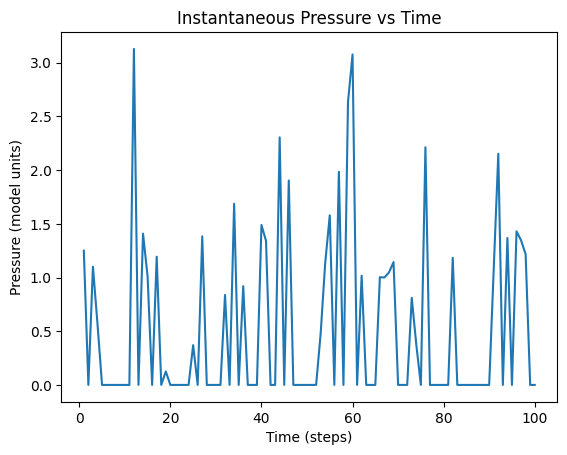

In [162]:
# Geef je oplossing

#your code/answer
pressures = np.zeros(100, dtype=float)
times = np.linspace(1, 100, 100)

create_particles(particles) # Reset de deeltjes

for i in range(100):
    take_time_step(particles)
    # De variabele 'pressure' is nu geupdatet door handle_walls
    pressures[i] = pressure

# 3. Plotten
plt.figure()
plt.xlabel('Time (steps)')
plt.ylabel('Pressure (model units)')
plt.plot(times, pressures)
plt.title('Instantaneous Pressure vs Time')
plt.show()


Verklaring:
De grafiek toont geen vlakke lijn, maar bestaat uit een reeks scherpe pieken met daartussen periodes waarin de druk nul (of heel laag) is.Dit komt doordat druk op microscopisch niveau het gevolg is van discrete botsingen.

Druk is gedefinieerd als de kracht per oppervlakte ($P = F/A$). In een gas wordt deze kracht veroorzaakt doordat individuele deeltjes tegen de wand botsen en daarbij impuls overdragen.

In onze simulatie hebben we slechts een klein aantal deeltjes ($N=40$) en een kleine tijdstap ($DT=0.01$).

In veel tijdstappen botst er geen enkel deeltje tegen de wand. De berekende druk is op dat moment dus exact 0.

Alleen op de momenten dat er toevallig één (of meer) deeltjes de wand raken, vindt er een impulsverandering plaats. Omdat we deze impuls delen door een zeer kleine tijdstap $\Delta t$ ($F \approx \Delta p / \Delta t$), resulteert zelfs een enkele botsing in een zeer hoge, kortstondige drukpiek.

## Verbeteren van code: middelen

De grafiek voor de druk bestaat uit een achtergrond op de waarde 0 en daarop een serie scherpe pieken.
Een piek komt overeen met een tijdstap waar er toevallig een atoom met de wanden botst.
Om deze grafiek meer constant te maken kunnen we het aantal deeltjes sterk verhogen door een veel groter volume te modelleren, maar dat kost ons veel meer rekenkracht.

```{exercise}
:label: ex-druktemp-5
Probeer bovenstaande simulatie uit te voeren met 400 deeltjes, vergeet niet je volume ook aan te passen (wat zou anders het gevolg zijn).

Klaar?
Zet je initiële waarden weer terug.
```

Een goedkoper alternatief bestaat uit het middelen van de druk over de tijd.
Fysisch is daar geen echte reden voor, maar ook meetinstrumenten in het laboratorium bepalen hun meetwaarde gedurende een tijdsinterval om hun ruis te verlagen. 

In de code doen we dit door de druk in de $i$-de tijdstap ($P_i$) niet volledig te laten bepalen door de druk tijdens de tijdstap waarin de simulatie plaatsvindt ($P$), maar door de druk in de vorige tijdstap ($P_{i-1}$) mee te nemen. 

$$ 
    P_{i} = \alpha * P + (1-\alpha) * P_{i-1}
$$

Door de factoren op deze manier netjes te kiezen, verandert de netto waarde voor de druk niet want voor $|\alpha| < 1$ geldt:

$$ 
    \sum_{i=0}^{\infty}(\alpha^k)(1-\alpha) =  \frac{1}{1-\alpha}(1-\alpha) = 1 
$$ (int_norm)

Merk op dat een waarde $\alpha=1$ ons weer terugbrengt bij een simulatie voor de druk zonder exponentieel voortschrijdend gemiddelde.
Daarbij, kleine waarden voor $\alpha$ (0.01-0.1) leveren sterke demping op.
Het signaal wordt 'smooth' maar reageert traag op veranderingen in de echte druk. 
Voor grotere waarden voor $\alpha$ geldt dat er weinig demping is.

Simulatie gestart met N=400 en Box Size=20.00...


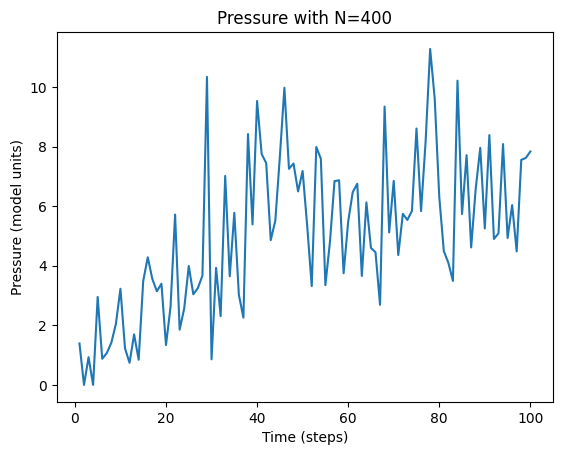

In [163]:
# Exercise 6: Simulatie met 400 deeltjes

N = 400

BOX_SIZE_0 = 20 

# Herinitialiseer de arrays en lijsten
particles = []
pressures = np.zeros(100, dtype=float)
times = np.linspace(1, 100, 100)

create_particles(particles) # Maakt nu 400 deeltjes aan in de grotere doos

# 2. Draai de simulatie
print(f"Simulatie gestart met N={N} en Box Size={BOX_SIZE_0:.2f}...")
for i in range(100):
    take_time_step(particles)
    pressures[i] = pressure

# 3. Plot het resultaat
plt.figure()
plt.xlabel('Time (steps)')
plt.ylabel('Pressure (model units)')
plt.plot(times, pressures)
plt.title(f'Pressure with N={N}')
plt.show()


In [164]:
# Herstelt de originele waarden
N = 40
BOX_SIZE_0 = 10    
RADIUS = 0.05
V_0 = 5

particles = []
create_particles(particles)


In [165]:
def handle_walls(particles):
    """ botsing met wanden controleren voor alle deeltjes in lijst en gemiddeld bepaling druk """
    global pressure, impulse_outward       # om pressure buiten de functie te kunnen gebruiken
    impulse_outward = 0.0
    for p in particles:
        left_right_collision(p)
        top_down_collision(p)    
    alpha = 0.1
    pressure = alpha * impulse_outward / (4 * BOX_SIZE_0 * DT) + (1-alpha) * pressure # omtrek volume is oppervlak (2D sim)

```{exercise}
Kopieer nu je code voor de simulatie waarin je de druk als functie van de tijd hebt geplot naar onderstaand veld en voer de simulatie nogmaals uit met de nieuwe definitie voor de functie `handle_walls`.
```

Simulatie gestart met N=40 en Box Size=10.00...


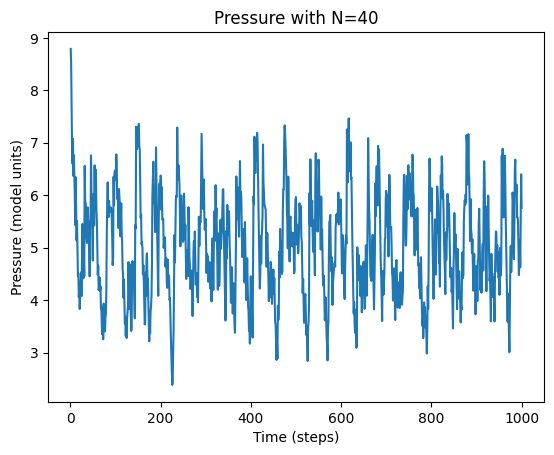

In [166]:
def handle_walls(particles):
    """ botsing met wanden controleren voor alle deeltjes in lijst en gemiddeld bepaling druk """
    global pressure, impulse_outward       # om pressure buiten de functie te kunnen gebruiken
    impulse_outward = 0.0
    for p in particles:
        left_right_collision(p)
        top_down_collision(p)    
    alpha = 0.1
    pressure = alpha * impulse_outward / (4 * BOX_SIZE_0 * DT) + (1-alpha) * pressure # omtrek volume is oppervlak (2D sim)

particles = []
pressures = np.zeros(1000, dtype=float)
times = np.linspace(1, 1000, 1000)
create_particles(particles) # Maakt nu 400 deeltjes aan in de grotere doos

# 2. Draai de simulatie
print(f"Simulatie gestart met N={N} en Box Size={BOX_SIZE_0:.2f}...")
for i in range(1000):
    take_time_step(particles)
    pressures[i] = pressure

# 3. Plot het resultaat
plt.figure()
plt.xlabel('Time (steps)')
plt.ylabel('Pressure (model units)')
plt.plot(times, pressures)
plt.title(f'Pressure with N={N}')
plt.show()


In [167]:
# Exercise 10: Verificatie met de theorie

# 1. Berekent de theoretische druk op basis van de huidige snelheden
total_kin_energy = 0.0
for p in particles:
    total_kin_energy += p.kin_energy

# In 2D is het 'Volume' gelijk aan het oppervlak (L^2)
area = BOX_SIZE_0**2
theoretical_pressure = total_kin_energy / area

# 2. Berekent de gemiddelde gemeten druk uit de vorige simulatie
measured_pressure = np.mean(pressures)

# 3. Print de resultaten
print(f"Theoretische druk (E_kin / V): {theoretical_pressure:.4f}")
print(f"Gemeten druk (Simulatie):      {measured_pressure:.4f}")

difference = abs(theoretical_pressure - measured_pressure)
percentage = (difference / theoretical_pressure) * 100
print(f"Afwijking: {percentage:.2f}%")

# Conclusie
if percentage < 5.0:
    print("De code is geverifieerd! De waarden komen goed overeen.")
else:
    print("Er is een grote afwijking. Controleer of alpha groot genoeg is of de simulatie lang genoeg duurt.")

Theoretische druk (E_kin / V): 5.0000
Gemeten druk (Simulatie):      5.0393
Afwijking: 0.79%
De code is geverifieerd! De waarden komen goed overeen.


In [de formule voor de tweedimensionale druk](#2d_pressure) kan je de structuur van de ideale gaswet herkennen. 

```{exercise}
:label: ex-druktemp9b

Herleid dezelfde formule af voor het driedimensionale geval. Laat zien welke relatie er geldt tussen de constanten voor het macroscopische (thermodynamische) model en het microscopische (mechanische) model.
```

```{solution} ex-druktemp9b
# Exercise 11: Afleiding 3D druk en relatie constanten

"""
AFLEIDING VOOR 3D:
1. Druk is kracht per oppervlakte: P = F / A.
   In een kubus met zijde L is het volume V = L^3 en het oppervlak van een wand A = L^2.

2. Voor één deeltje i dat botst met de wand in de x-richting geldt:
   - Verandering van impuls (stoot): Δp = 2 * m * v_x,i
   - Tijd tussen twee botsingen met dezelfde wand: Δt = 2 * L / v_x,i
   - Gemiddelde kracht van dit deeltje op de wand: 
     F_i = Δp / Δt = (2 * m * v_x,i) / (2 * L / v_x,i) = (m * v_x,i^2) / L

3. De totale kracht is de som over alle N deeltjes:
   F_totaal = Σ F_i = (m / L) * Σ (v_x,i^2)
            = (m * N / L) * <v_x^2>  (waarbij <v_x^2> het gemiddelde is)

4. De druk P is F_totaal / A:
   P = ((m * N / L) * <v_x^2>) / L^2
   P = (m * N / L^3) * <v_x^2>
   P = (m * N / V) * <v_x^2>

5. In 3D bewegen deeltjes willekeurig in alle richtingen:
   <v^2> = <v_x^2> + <v_y^2> + <v_z^2>
   Omdat er geen voorkeursrichting is geldt: <v_x^2> = <v_y^2> = <v_z^2>
   Dus: <v^2> = 3 * <v_x^2>  ==>  <v_x^2> = <v^2> / 3

6. Invullen in de drukformule geeft het 3D resultaat:
   P = (m * N / V) * (<v^2> / 3)
   PV = (1/3) * N * m * <v^2>

RELATIE CONSTANTEN (Microscopisch vs Macroscopisch):
We kunnen de bovenstaande formule herschrijven in termen van kinetische energie (<E_kin> = 0.5 * m * <v^2>):
   PV = (2/3) * N * (0.5 * m * <v^2>)
   PV = (2/3) * N * <E_kin>

De macroscopische Ideale Gaswet luidt:
   PV = N * k_B * T

Als we deze twee aan elkaar gelijkstellen:
   N * k_B * T = (2/3) * N * <E_kin>
   k_B * T = (2/3) * <E_kin>
   
   Oftewel: <E_kin> = (3/2) * k_B * T

CONCLUSIE:
De macroscopische constante 'Temperatuur' (T) is een directe maat voor de microscopische 'Gemiddelde Kinetische Energie' (<E_kin>). 
De Boltzmann-constante (k_B) is de schaalfactor die deze twee werelden (mechanische energie in Joules en thermodynamische temperatuur in Kelvin) met elkaar verbindt. De factor 3/2 komt voort uit de 3 ruimtelijke dimensies.
"""
```

```{exercise}
:label: ex-druktemp-12
Laat je werk aftekenen door een TA en besluit of je eventueel wil doorgaan met de verdiepende opdracht voor een 'excellent' op dit onderdeel.
```

```{exercise} 🌶 Uitbreiding
:label: ex-druktemp-13
Je ziet dat de druk een statistisch bepaalde grootheid is die met de tijd varieert. Het is interessant om dit te onderzoeken.

- Maak een histogram van de drukwaardes die je meet gedurende een simulatie.
- Maak de lengte van de simulatie lang genoeg zodat dit histogram op het oog voldoende reproduceert.
- Bepaal de breedte van de verdeling van drukwaardes met een eigen gekozen definitie.
- Verhoog het aantal deeltjes met een factor twee en herhaal je berekening.
- Schat hieruit de statistische variatie in de druk bij een volume met $10^{23}$ deeltjes.


Start simulatie met N=50...
Start simulatie met N=100...
N=50:   Relatieve spreiding = 0.1777
N=100:  Relatieve spreiding = 0.1335
Factor verbetering: 1.33 (Verwachting: √2 ≈ 1.41)


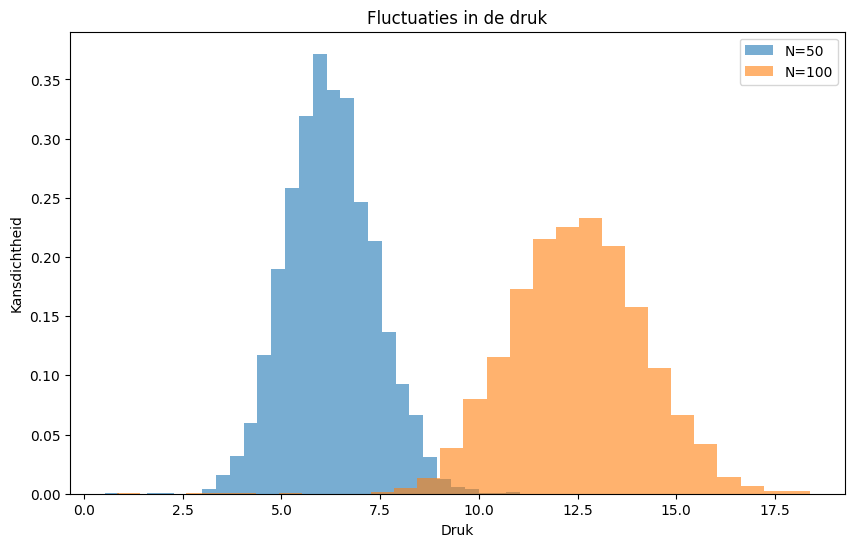

In [ ]:
# Exercise 13: Statistiek van de druk (met bestaande code)

import matplotlib.pyplot as plt
import numpy as np

# Functie voor de gemeten druk met een specifiek aantal deeltjes
def run_experiment(num_particles, steps=5000):
    global N, pressure, impulse_outward, particles # Verwijs naar de globale variabelen
    
    # 1. Pas de globale N aan en reset de simulatie
    N = num_particles
    particles = []
    create_particles(particles) # Gebruikt de nieuwe N
    
    # Reset druk variabelen
    pressure = 0.0
    impulse_outward = 0.0
    
    measured_pressures = []

    # 3. Meten
    for _ in range(steps):
        take_time_step(particles)
        measured_pressures.append(pressure)
        
    return np.array(measured_pressures)

# --- UITVOERING ---
# Experiment 1: Met 50 deeltjes
base_N = 50 
data_1 = run_experiment(base_N)

# Experiment 2: Met dubbel zoveel deeltjes
double_N = base_N * 2
data_2 = run_experiment(double_N)

# --- ANALYSE & PLOTTEN ---

mean1, std1 = np.mean(data_1), np.std(data_1)
mean2, std2 = np.mean(data_2), np.std(data_2)

rel_1 = std1 / mean1
rel_2 = std2 / mean2

print(f"N={base_N}:   Relatieve spreiding = {rel_1:.4f}")
print(f"N={double_N}:  Relatieve spreiding = {rel_2:.4f}")


# Histogram maken
plt.figure(figsize=(10, 6))
plt.hist(data_1, bins=30, density=True, alpha=0.6, label=f'N={base_N}')
plt.hist(data_2, bins=30, density=True, alpha=0.6, label=f'N={double_N}')
plt.xlabel('Druk')
plt.ylabel('Kansdichtheid')
plt.title('Fluctuaties in de druk')
plt.legend()
plt.show()
